# Multinomial Regression
See Statistical Rethinking sections 10.1.3 for fit using
Binomical Regression, 10.3 and 10.3.1.2 for Multinomial and Poisson trick.
Also BDA3 p426

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import os
n_devices = 16
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

In [3]:
from io import BytesIO

In [4]:
# https://raw.githubusercontent.com/rmcelreath/rethinking/refs/heads/master/data/UCBadmit.csv
# Modified: applicant.gender -> gender

uc_admit_csv = """"dept";"gender";"admit";"reject";"applications"
"1";"A";"male";512;313;825
"2";"A";"female";89;19;108
"3";"B";"male";353;207;560
"4";"B";"female";17;8;25
"5";"C";"male";120;205;325
"6";"C";"female";202;391;593
"7";"D";"male";138;279;417
"8";"D";"female";131;244;375
"9";"E";"male";53;138;191
"10";"E";"female";94;299;393
"11";"F";"male";22;351;373
"12";"F";"female";24;317;341"""

In [5]:
df = pd.read_csv(BytesIO(uc_admit_csv.encode("utf-8")), sep=";").sort_values(['dept', 'gender'])

In [6]:
df

dept  gender  admit  reject  applications
2     A  female     89      19           108
1     A    male    512     313           825
4     B  female     17       8            25
3     B    male    353     207           560
6     C  female    202     391           593
5     C    male    120     205           325
8     D  female    131     244           375
7     D    male    138     279           417
10    E  female     94     299           393
9     E    male     53     138           191
12    F  female     24     317           341
11    F    male     22     351           373

In [7]:
# Admission rate - population level
df_p = df.groupby('gender')[['admit', 'applications']].sum().assign(
    admit_rate=lambda x: x.admit/x.applications
)
df_p

admit  applications  admit_rate
gender                                 
female    557          1835    0.303542
male     1198          2691    0.445188

In [8]:
odds_ratio_diff = (
        np.log(df_p.loc['male', 'admit_rate'] /
               (1- df_p.loc['male', 'admit_rate']))
        - np.log(df_p.loc['female', 'admit_rate'] /
                 (1- df_p.loc['female', 'admit_rate']))
)
odds_ratio_diff

0.6103523761464004

In [9]:
# Admission rate - by department
df.groupby(['dept', 'gender'])[['admit', 'applications']].sum().assign(
    admit_rate=lambda x: x.admit/x.applications
)['admit_rate'].unstack()

gender    female      male
dept                      
A       0.824074  0.620606
B       0.680000  0.630357
C       0.340641  0.369231
D       0.349333  0.330935
E       0.239186  0.277487
F       0.070381  0.058981

The above is an example of Simpson's paradox whereby a population level
trend gets reversed if we consider the sub-populations.

The raw summary statistics give us a point estimate of the rates
but lose the spread of distribution so we can't determine the
statistical significance.

In [10]:
groups = ['female', 'male']
idx = pd.Categorical(df.gender, groups).codes

with pm.Model() as binomial_model:
    a = pm.Normal('a', mu=0, sigma=10)
    bm = pm.Normal('b', mu=0, sigma=10)
    admit_rate = pm.Deterministic('admit_rate', pm.math.invlogit(a + bm*idx))
    admit = pm.Binomial(
        'admit', n=df['applications'], p=admit_rate, observed=df['admit']
    )

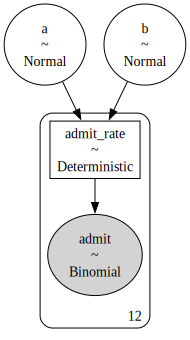

In [11]:
pm.model_to_graphviz(binomial_model)

In [12]:
with binomial_model:
    idata = pm.sample(1000, random_seed=42, nuts_sampler='blackjax', chains=n_devices, progressbar=False)

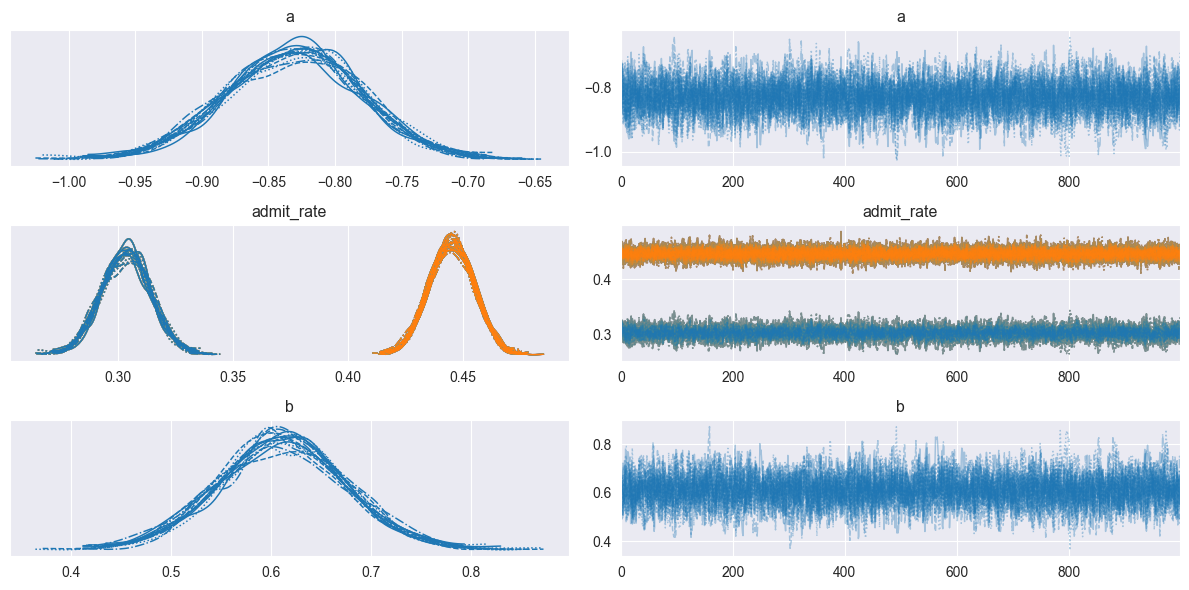

In [13]:
az.plot_trace(idata)
plt.tight_layout()

<Axes: title={'center': 'b'}>

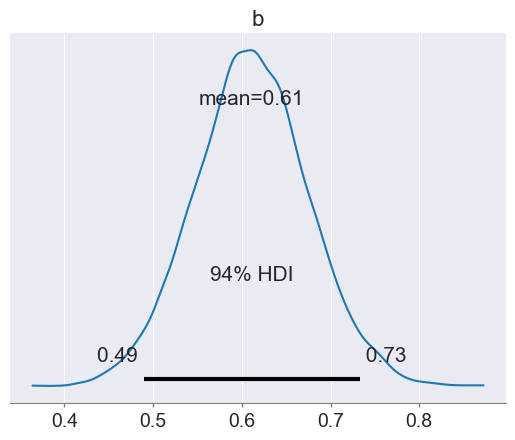

In [14]:
# Mean agrees with population level summary stats and
az.plot_posterior(idata, ['b'])

In [15]:
applications_obs = df.set_index(['dept', 'gender'])[['applications']].unstack().values

In [16]:
admit_obs = df.set_index(['dept', 'gender'])[['admit']].unstack().values

In [17]:
# Q: what happens if there is missing data?
# A: model construction gives warning that it will be imputed
# and sampling with NUTS fails due to non-differentiability
# admit_obs = admit_obs.astype(float)
# admit_obs[5, 0] = np.nan

In [18]:
dept = sorted(df.dept.unique())
gender = ['female', 'male']
coords = {'dept': dept, 'gender': gender}

In [112]:
pd.factorize(df.dept.values)

(array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]),
 array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object))

In [106]:
# Separate model for each dept, universal gender slope - this is m10.9 in Statistical Rethinking
with pm.Model(coords=coords) as binomial_dept_model:
    a = pm.Normal('a', mu=0, sigma=10, dims=['dept'])
    bm = pm.Normal('b', mu=0, sigma=10)  # , dims=['gender'])
    admit_rate = pm.Deterministic(
        'admit_rate',
        pm.math.invlogit(
            a.reshape((len(dept), 1)) + idx.reshape((len(dept), len(gender)))*bm
        ), dims=['dept', 'gender'])
    admit = pm.Binomial(
        'admit', n=applications_obs, p=admit_rate, observed=admit_obs,
        dims=['dept', 'gender']
    )

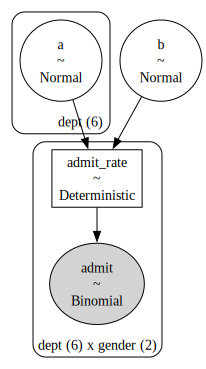

In [107]:
pm.model_to_graphviz(binomial_dept_model)

In [108]:
with binomial_dept_model:
    idata_dept = pm.sample(1000, random_seed=42, nuts_sampler='blackjax', chains=n_devices, progressbar=False)

In [109]:
az.summary(idata_dept, var_names=['a', 'b'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[A]  0.683  0.100   0.504    0.878      0.001    0.001    8218.0   11076.0   
a[B]  0.641  0.117   0.422    0.861      0.001    0.001    8709.0   10405.0   
a[C] -0.583  0.074  -0.724   -0.445      0.001    0.001   13213.0   12487.0   
a[D] -0.613  0.086  -0.777   -0.451      0.001    0.001   10891.0   11332.0   
a[E] -1.060  0.099  -1.250   -0.879      0.001    0.001   14373.0   12026.0   
a[F] -2.633  0.158  -2.938   -2.345      0.001    0.001   15868.0   12144.0   
b    -0.101  0.081  -0.247    0.060      0.001    0.001    6585.0    9544.0   

      r_hat  
a[A]    1.0  
a[B]    1.0  
a[C]    1.0  
a[D]    1.0  
a[E]    1.0  
a[F]    1.0  
b       1.0

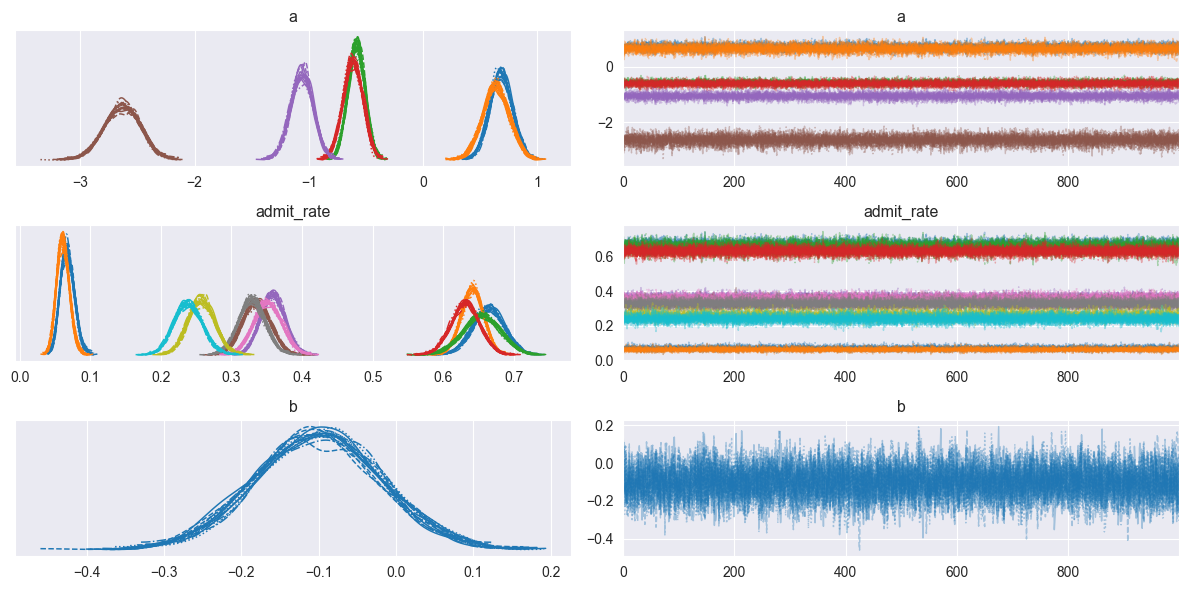

In [110]:
az.plot_trace(idata_dept)
plt.tight_layout()

array([[<Axes: title={'center': 'a\nA'}>,
        <Axes: title={'center': 'a\nB'}>,
        <Axes: title={'center': 'a\nC'}>],
       [<Axes: title={'center': 'a\nD'}>,
        <Axes: title={'center': 'a\nE'}>,
        <Axes: title={'center': 'a\nF'}>],
       [<Axes: title={'center': 'b'}>, <Axes: >, <Axes: >]], dtype=object)

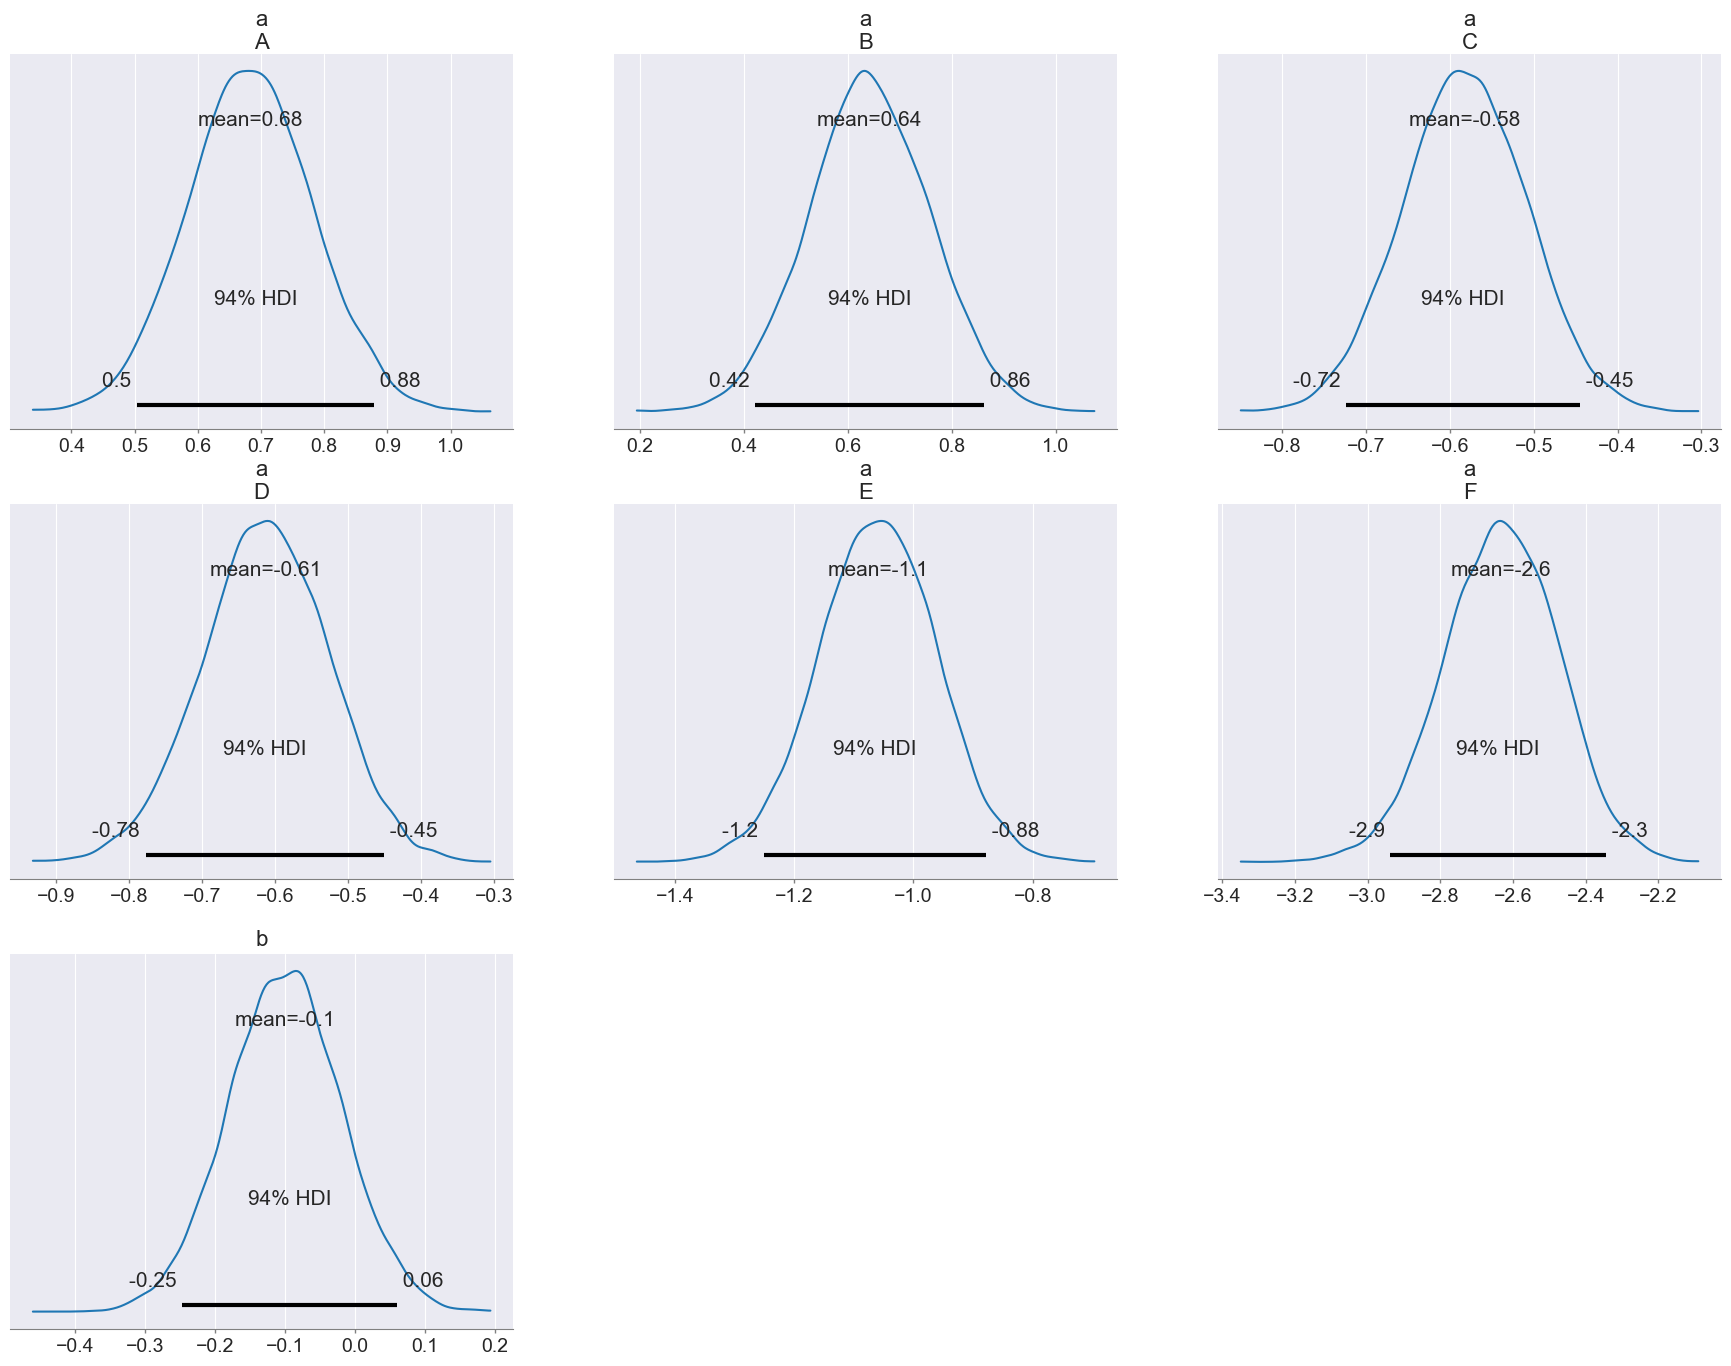

In [111]:
az.plot_posterior(idata_dept, var_names=['a', 'b'])

In [113]:
# Separate model for each dept-gender combination
with pm.Model(coords=coords) as binomial_group_model:
    a = pm.Normal('a', mu=0, sigma=10, dims=['dept', 'gender'])
    # bm = pm.Normal('b', mu=0, sigma=10, dims=['dept', 'gender'])
    admit_rate = pm.Deterministic('admit_rate', pm.math.invlogit(
        a # + bm
    ), dims=['dept', 'gender'])
    admit = pm.Binomial(
        'admit', n=applications_obs, p=admit_rate, observed=admit_obs,
        dims=['dept', 'gender']
    )

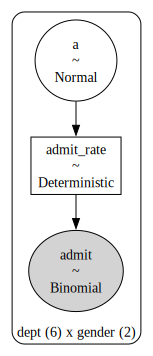

In [114]:
pm.model_to_graphviz(binomial_group_model)

In [115]:
with binomial_group_model:
    idata_group = pm.sample(1000, random_seed=42, nuts_sampler='blackjax', chains=n_devices, progressbar=False)

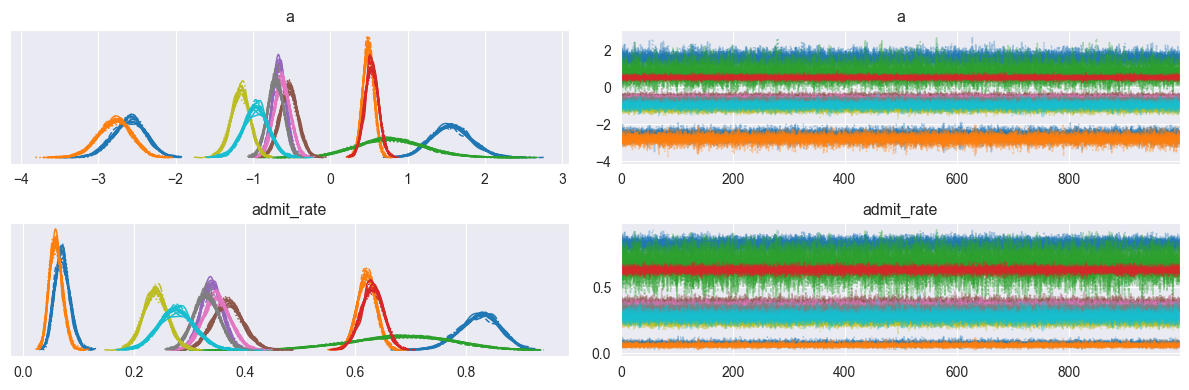

In [116]:
az.plot_trace(idata_group)
plt.tight_layout()

array([[<Axes: title={'center': 'a\nA, female'}>,
        <Axes: title={'center': 'a\nA, male'}>],
       [<Axes: title={'center': 'a\nB, female'}>,
        <Axes: title={'center': 'a\nB, male'}>],
       [<Axes: title={'center': 'a\nC, female'}>,
        <Axes: title={'center': 'a\nC, male'}>],
       [<Axes: title={'center': 'a\nD, female'}>,
        <Axes: title={'center': 'a\nD, male'}>],
       [<Axes: title={'center': 'a\nE, female'}>,
        <Axes: title={'center': 'a\nE, male'}>],
       [<Axes: title={'center': 'a\nF, female'}>,
        <Axes: title={'center': 'a\nF, male'}>]], dtype=object)

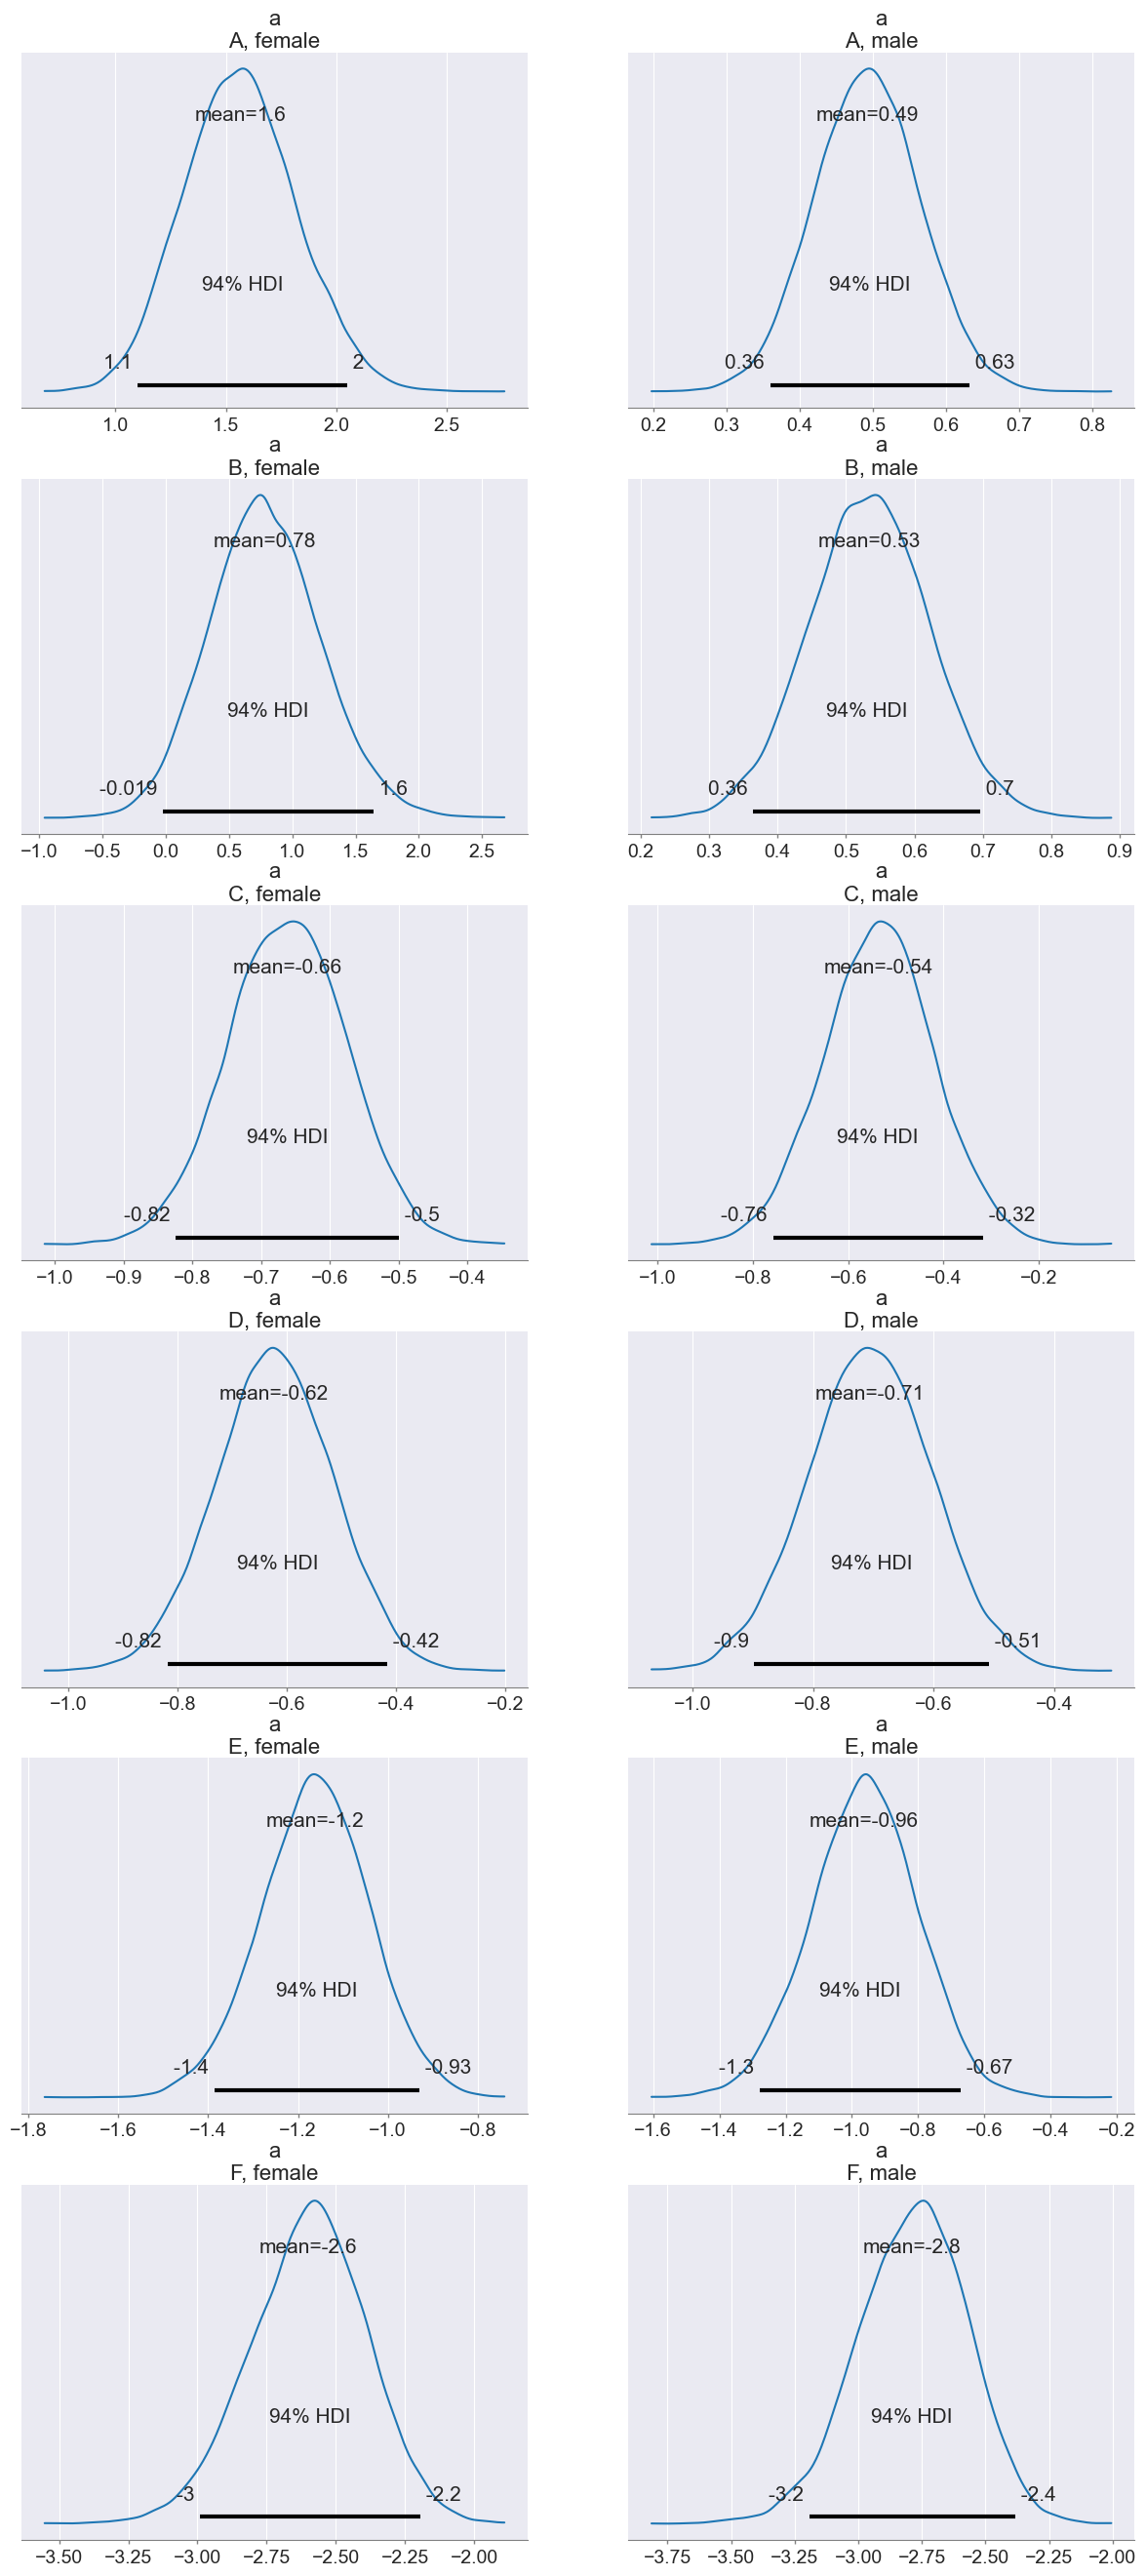

In [117]:
az.plot_posterior(idata_group, ['a'], grid=admit_obs.shape)

Flattened version

In [58]:
groups = (df.dept + '_' + df.gender).tolist()
# groups = df.dept.tolist()  # Ignore gender
# groups

In [59]:
coords_flat = {'dept_gender': groups}
with pm.Model(coords=coords_flat) as binomial_group_model_flat:
    a = pm.Normal('a', mu=0, sigma=10, dims=['dept_gender'])
    bm = pm.Normal('b', mu=0, sigma=10, dims=['dept_gender'])
    admit_rate = pm.Deterministic('admit_rate', pm.math.invlogit(a + bm), dims=['dept_gender'])
    admit = pm.Binomial(
        'admit', n=df['applications'], p=admit_rate, observed=df['admit'],
        dims=['dept_gender']
    )

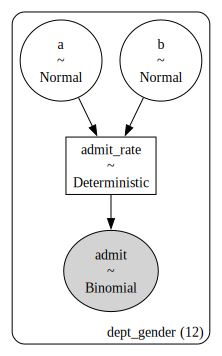

In [60]:
pm.model_to_graphviz(binomial_group_model_flat)

In [61]:
with binomial_group_model_flat:
    idata_group_flat = pm.sample(1000, random_seed=42, nuts_sampler='blackjax', chains=n_devices, progressbar=False)

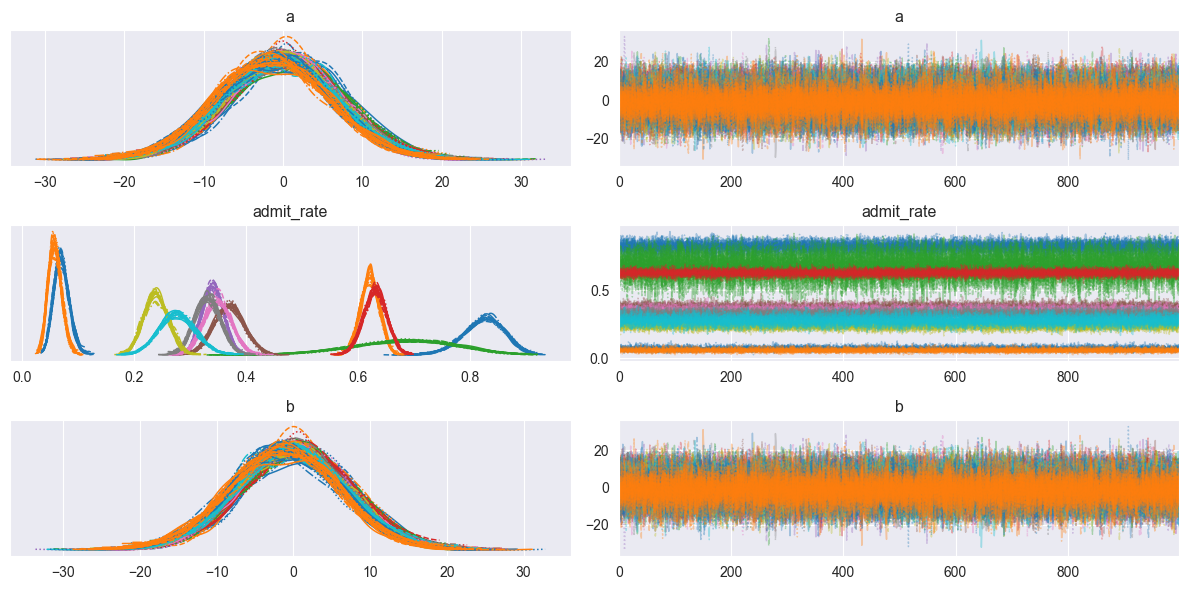

In [62]:
az.plot_trace(idata_group_flat)
plt.tight_layout()

array([[<Axes: title={'center': 'b\nA_female'}>,
        <Axes: title={'center': 'b\nA_male'}>],
       [<Axes: title={'center': 'b\nB_female'}>,
        <Axes: title={'center': 'b\nB_male'}>],
       [<Axes: title={'center': 'b\nC_female'}>,
        <Axes: title={'center': 'b\nC_male'}>],
       [<Axes: title={'center': 'b\nD_female'}>,
        <Axes: title={'center': 'b\nD_male'}>],
       [<Axes: title={'center': 'b\nE_female'}>,
        <Axes: title={'center': 'b\nE_male'}>],
       [<Axes: title={'center': 'b\nF_female'}>,
        <Axes: title={'center': 'b\nF_male'}>]], dtype=object)

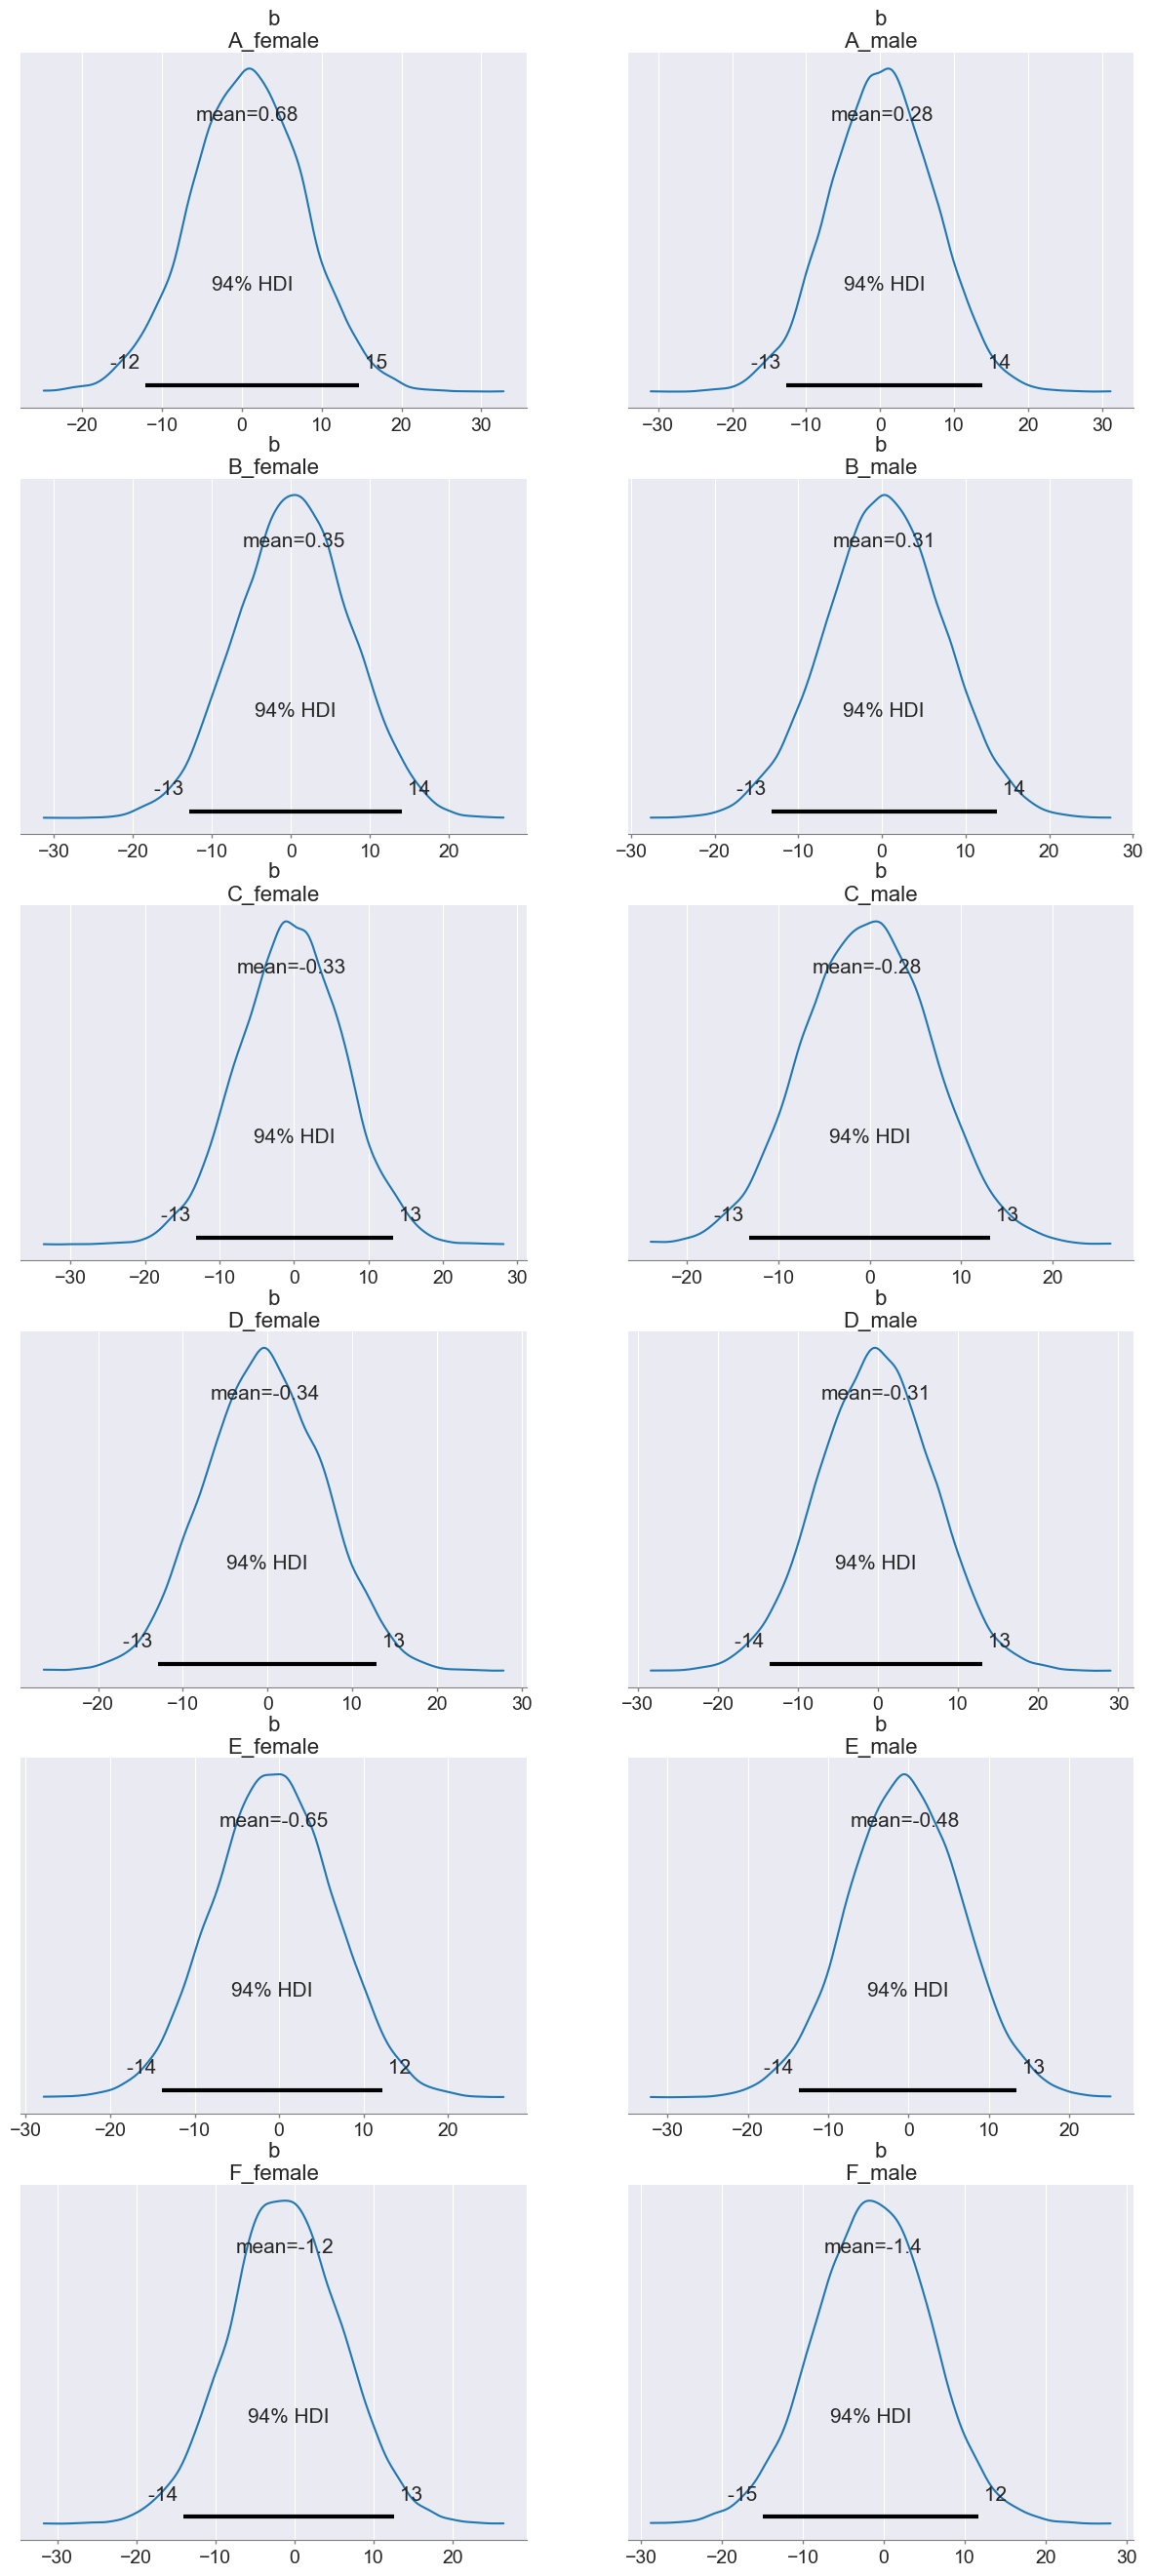

In [63]:
az.plot_posterior(idata_group_flat, ['b'], grid=np.array(groups).reshape((-1, 2)).shape)


Hierachical model

In [42]:
with pm.Model(coords=coords) as binomial_hier_group_model:
    a_mu = pm.Normal('a_mu', mu=0, sigma=10)
    b_mu = pm.Normal('b_mu', mu=0, sigma=10)
    a = pm.Normal('a', mu=a_mu, sigma=10, dims=['dept', 'gender'])

    # Centered
    # bm = pm.Normal('b', mu=b_mu, sigma=10, dims=['dept', 'gender'])

    # Uncentred
    b = pm.Normal('b', mu=0, sigma=10, dims=['dept', 'gender'])
    bm = pm.Deterministic('b_uncentered', b_mu + b, dims=['dept', 'gender'])

    admit_rate = pm.Deterministic('admit_rate', pm.math.invlogit(a + bm), dims=['dept', 'gender'])
    admit = pm.Binomial(
        'admit', n=applications_obs, p=admit_rate, observed=admit_obs,
        dims=['dept', 'gender']
    )

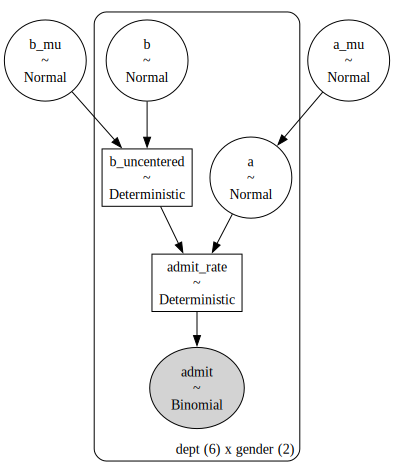

In [43]:
pm.model_to_graphviz(binomial_hier_group_model)

In [44]:
with binomial_hier_group_model:
    idata_hier_group = pm.sample(1000, random_seed=42, nuts_sampler='blackjax', chains=n_devices, progressbar=False)

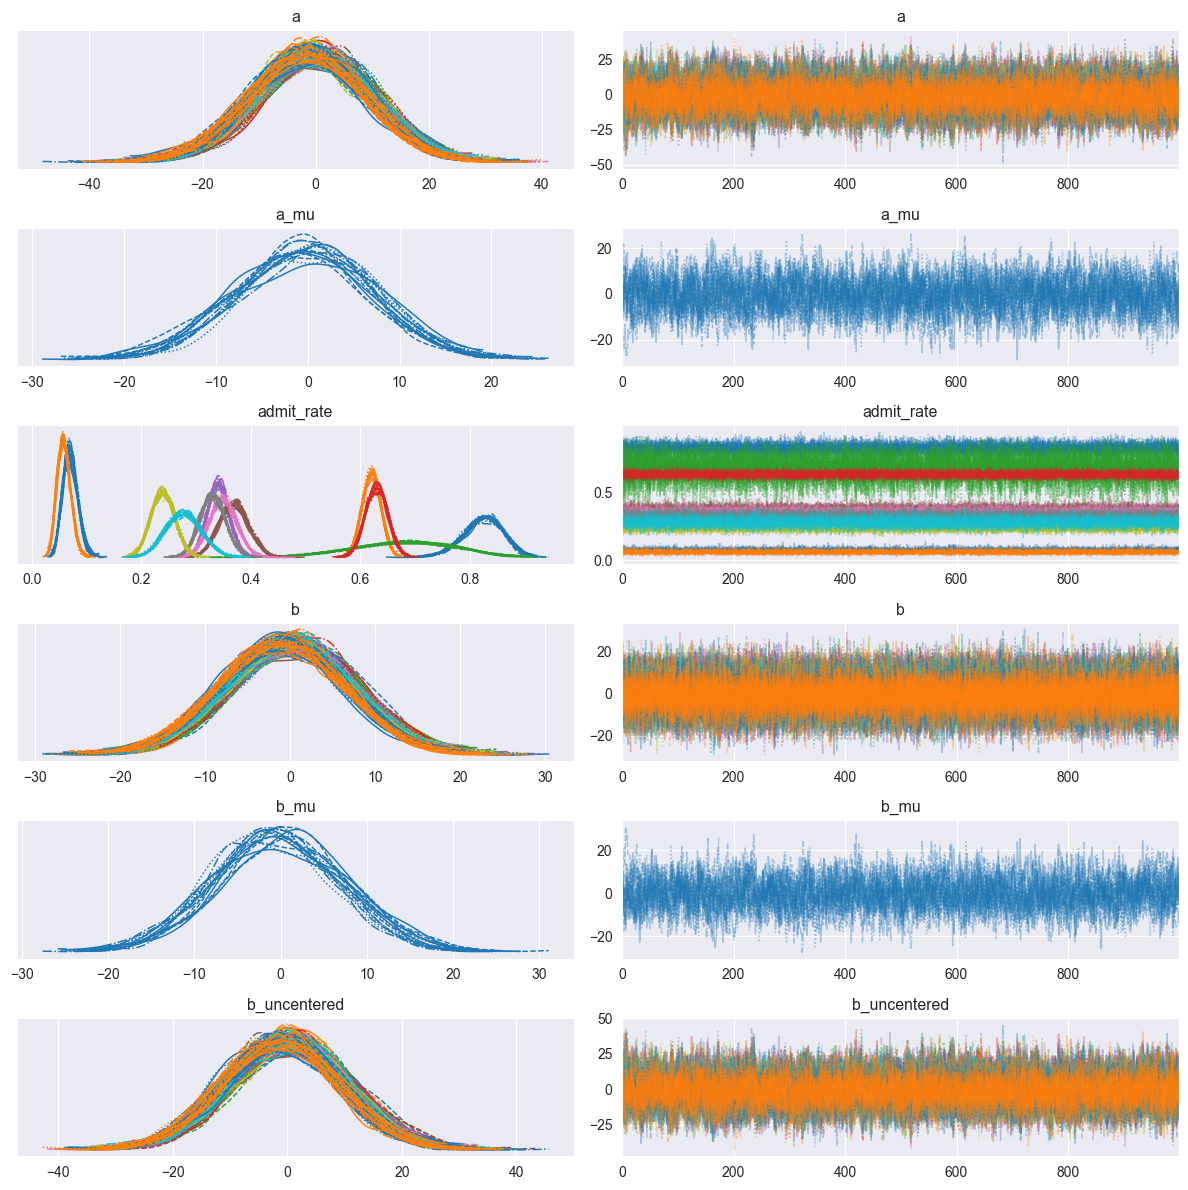

In [45]:
az.plot_trace(idata_hier_group)
plt.tight_layout()

array([[<Axes: title={'center': 'b\nA, female'}>,
        <Axes: title={'center': 'b\nA, male'}>],
       [<Axes: title={'center': 'b\nB, female'}>,
        <Axes: title={'center': 'b\nB, male'}>],
       [<Axes: title={'center': 'b\nC, female'}>,
        <Axes: title={'center': 'b\nC, male'}>],
       [<Axes: title={'center': 'b\nD, female'}>,
        <Axes: title={'center': 'b\nD, male'}>],
       [<Axes: title={'center': 'b\nE, female'}>,
        <Axes: title={'center': 'b\nE, male'}>],
       [<Axes: title={'center': 'b\nF, female'}>,
        <Axes: title={'center': 'b\nF, male'}>]], dtype=object)

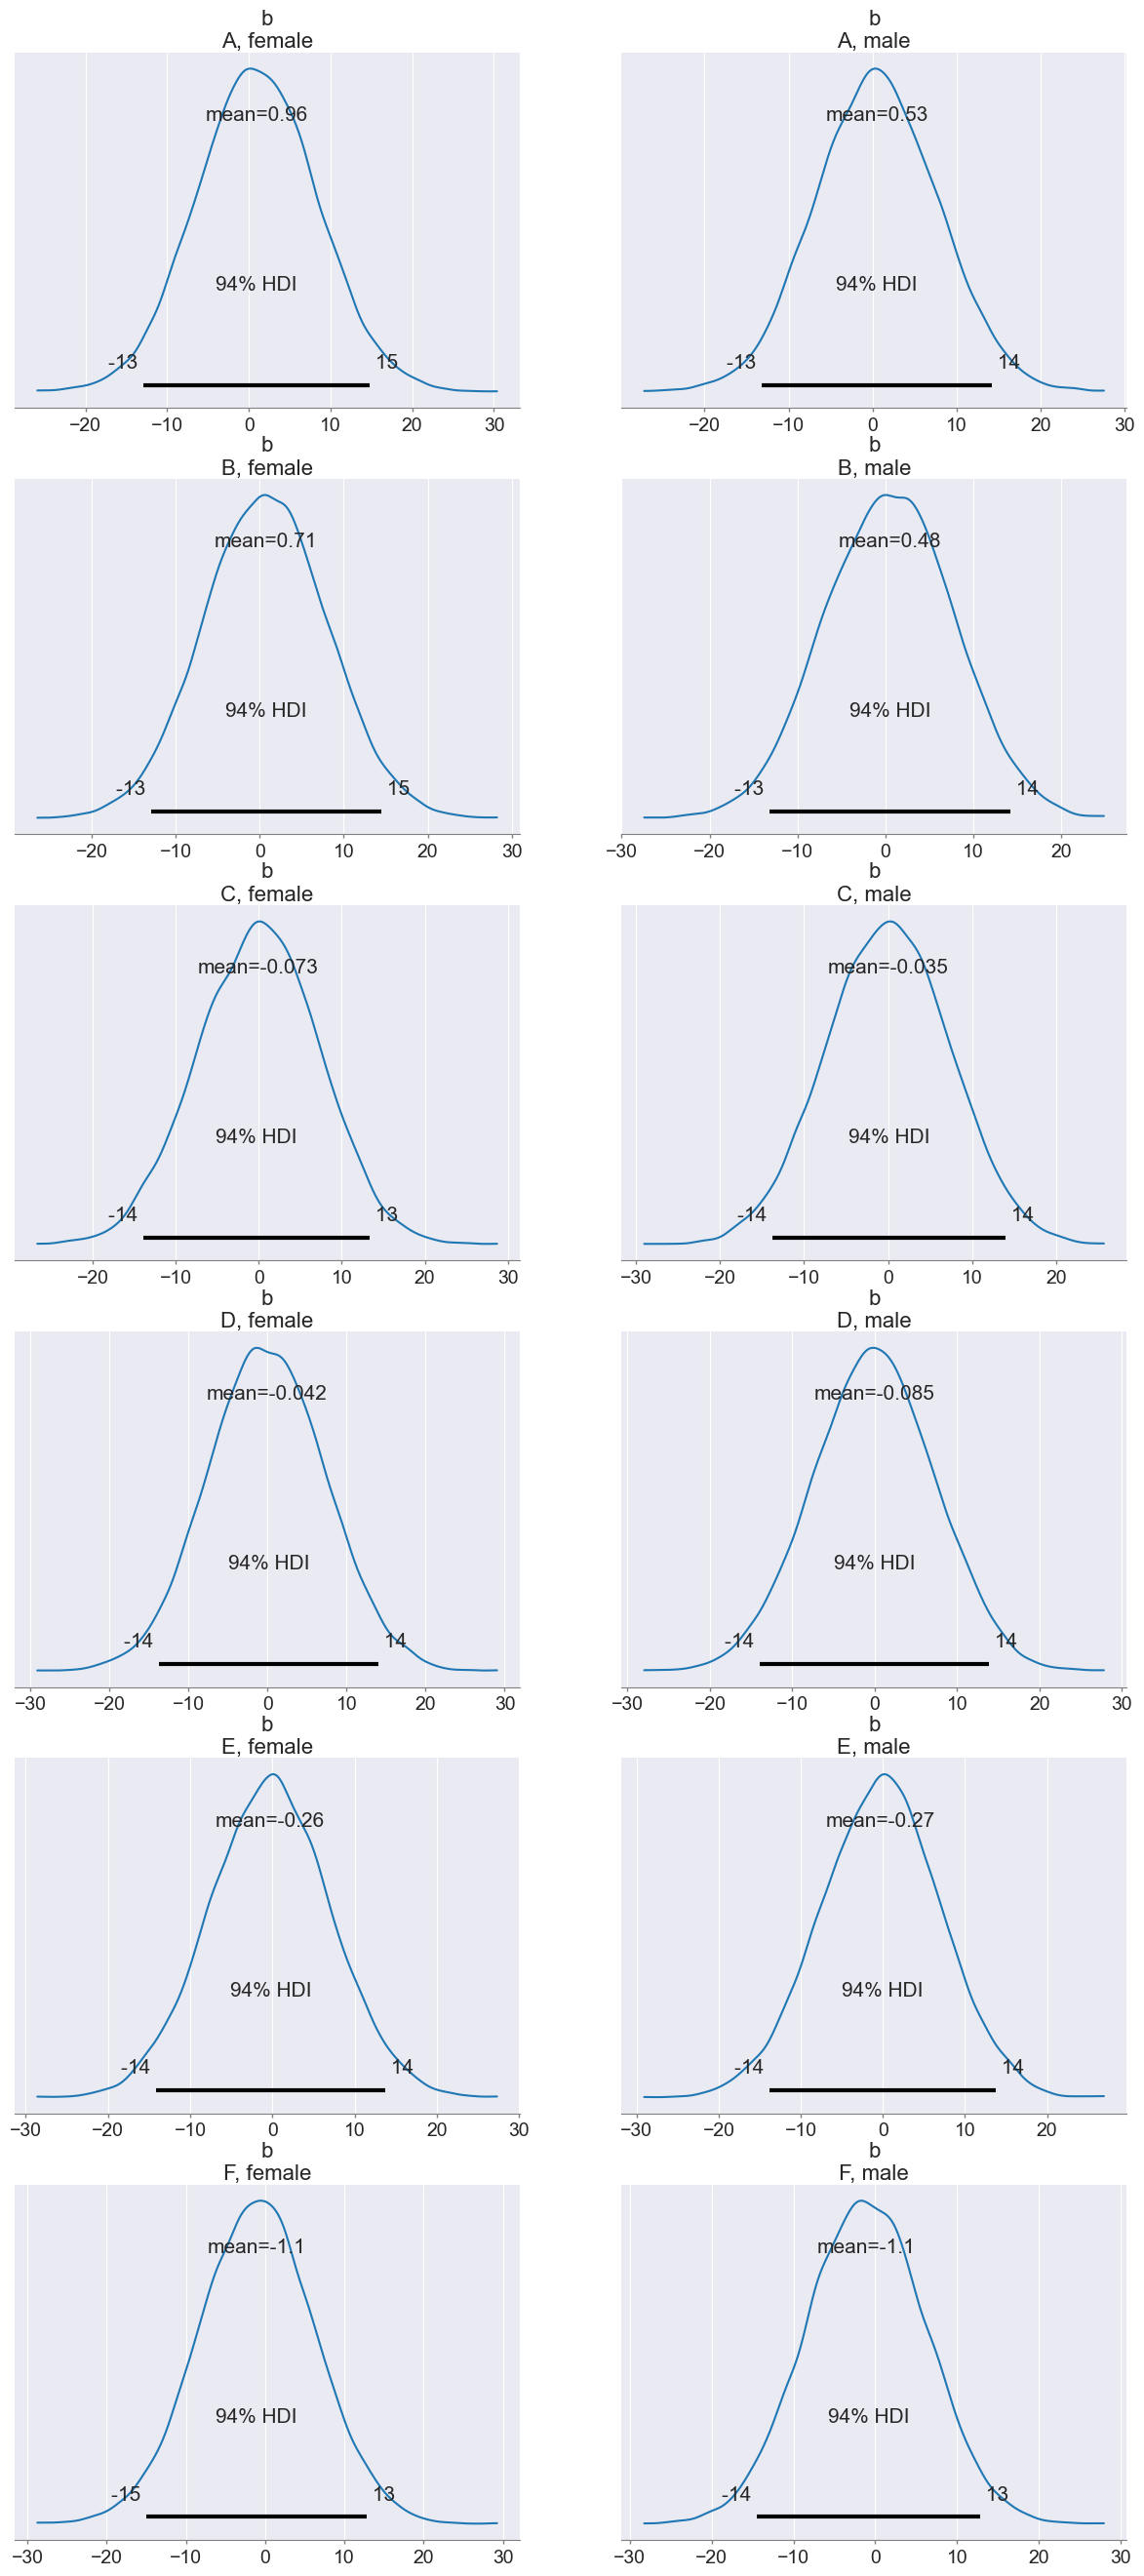

In [48]:
az.plot_posterior(idata_hier_group, ['b'], grid=admit_obs.shape)